<h1>Cloaking PTR</h1>

<h3>Code Imports</h3>

In [441]:
% matplotlib inline
import sympy as sp
import numpy as np
from  sympy import cos, sin, exp
from numpy import sqrt, log
from scipy.special import hankel1
from scipy.special import jv as besselj
from scipy.linalg import toeplitz
from matplotlib import pyplot as plt
from numpy import vectorize
from mpl_toolkits.mplot3d import Axes3D

<h3>Introduction</h3>

<b>Project Goals</b>
<ul> 
<li> Define the boundary and its properties
<li> From the boundary, define a function for the PTR
<li> Using equations from Kress and CKK, calculate density mu
<li> Using PTR, approximate the area outside the boundary from the function
<li> Using PTR, approximate the area inside the boundary from the function (next step)
<li> Plot PTR results
<li> Examine PTR results and error of approximate (next step)
</ul>

<h3>Variable Definitions</h3>

<img src="boundary_notes.JPG" alt="Drawing" style="width: 400px;" align="left"/>

<b> Of the Boundary</b><br>
M = Number of points on the boundary<br>
J = Jacobian<br>
τ = Tangent Vector<br>
ν = Normal Vector<br>
κ = Curvature

<b> Of the PTR Approximation</b><br>
f = Function of the density<br>
k = Wave Number<br>
μ = Density of the function<br>
x, y = Range of the outer area of boundary<br>
u = Plot of the area captured by the function

<h3>Boundary Class Definition</h3>

In [442]:
class Boundary:
    '''
    Defines the class Boundary, that contains geometric features of a boundary
    
    Attributes
    ==========
    param: parametrization of a boundary
    veloc: derivative of the parametrization
    accel: second derivative of the parametrization
    normal: normal vector to the boundary
    tangent: tangent vectors to the boundary
    curvature: signed curvature of the boundary
    jacobian: Jacobian of the boundary
    '''
    
    def __init__(self, b):
        self.y = b
    
    @property
    def yp(self):
        return [sp.diff(p, t) for p in self.y]
    @property
    def ypp(self):
        return [sp.diff(p, t) for p in self.yp]
    @property
    def J(self):
        v2 = [i**2 for i in self.yp]
        sv2 = sum(v2)
        return sp.sqrt(sv2).simplify()
    @property
    def τ(self):
        return [p/self.J for p in self.yp]
    @property
    def ν(self):
        if len(self.y) == 2:
            tmp = (self.yp[1]/self.J, -self.yp[0]/self.J )
            return tmp
        else:
            raise ValueError('Need to define the normal vector for higher dimensions')
    @property
    def κ(self): #curvature kappa
        if len(self.y) == 2:
            tmp = (self.yp[0]*self.ypp[1] - self.yp[1]*self.ypp[0])/self.J**3  
            return tmp.simplify()
        else:
            raise ValueError('Need to define the mean curvature for higher dimensions')
            
  #  def __call__(self, u, v):             #if one needs to call the function one can create stuff
  #      print("Hello ", self.κ)

<h3>Defined Boundary Curves</h3>

In [443]:
t = sp.Symbol('t')

Ellipse = (2*cos(t), 3*sin(t))
Circle = (cos(t), sin(t))
Star = ((1+0.3*cos(5*t))*cos(t), (1+0.3*cos(5*t))*sin(t))
Kite = ((cos(t) + 0.65*cos(2*t) -0.65, 1.5*sin(t)))

E = Boundary(Ellipse)
K = Boundary(Kite)
C = Boundary(Circle)
S = Boundary(Star)

<h3>Calculation of Density μ</h3>

In [468]:
## Solve for the density, μ
def find_μ(f, xbdy, ybdy, ν, J, κ):
    
    E_C = 0.5772156649015328606065120900824;  # Euler's constant
    N = M / 2;
    m = np.arange(1, N);

    # Create array for ifft...
    a = [0]
    a.extend(1/m)
    a.append(1/N)
    a.extend((1/m)[::-1])

    Rj = -2 * np.pi * np.fft.ifft(a);
    R = np.real(toeplitz(Rj, Rj));

    # Prepare arrays for solving integral equation of the boundary (Kress pt. 2)
    Kbdy = np.zeros((M, M), dtype=complex);
    L1 = np.zeros((M, M));
    L2 = np.zeros((M, M), dtype=complex);
    M1 = np.zeros((M, M));
    M2 = np.zeros((M, M), dtype=complex);

    for m in range(0, M):
        for n in range(0, M):
            rdiff = np.asarray([xbdy[m] - xbdy[n], ybdy[m] - ybdy[n]]);
            distance = sqrt(np.power(rdiff[:][0], 2) + np.power(rdiff[:][1], 2));
            M1[m][n] = -0.5 / np.pi * J[n] * besselj(0, k * distance);
            if m == n:
                L1[m][n] = 0;
                L2[m][n] = 0.5 / np.pi * κ[n] * J[n];
                M2[m][n] = J[n] * ( 0.5 * 1j - E_C / np.pi - 0.5 / np.pi * np.log( 0.25 * np.power(k, 2) * np.power(J[n], 2)));
            else:
                # Find a way to simplify these calculations?
                A = np.asmatrix([ν[0][n], ν[1][n]]);
                B = np.asmatrix(rdiff/distance);
                cosθ = np.asscalar(np.matmul(A, B.transpose()));
                
                logterm = log(float(4 * np.power(sin(0.5 * (m - n) * dt), 2)));
            
                L1[m][n] = 0.5 * k / np.pi * J[n] * cosθ * besselj(1, k * distance);
                L2[m][n] = -0.5 * 1j * k * J[n] * cosθ * hankel1(1, k * distance) - L1[m][n] * logterm;
                M2[m][n] = 0.5 * 1j * J[n] * hankel1(0, k * distance) - M1[m][n] * logterm;
    
            Kbdy[m][n] = 0.5 * R[m][n] * (L1[m][n] + 1j * k * M1[m][n]) + 0.5 * (np.pi / N) * (L2[m][n] + 1j * k * M2[m][n]);
        
    μ = 0.5 * np.identity(M) - Kbdy;
    #μ_inv = np.linalg.inv(μ);
    #μ = μ_inv.dot(f);
    μ = np.linalg.solve(μ,f);
    np.append(μ, μ[0]);
    return μ

# Have attempted multiple different ways of solving for mu, verifying method each time
# Result remains the same, and still seems off from Matlab results
# Consult about acceptable error / a mistake in method

<h3>Calculation of Solution Grid</h3>

In [445]:
## Preparing values for solution grid
# κappa_E = lambda u: np.array([p.subs(t,u).evalf() for p in E.κ]).T
def makegrid(ngrid, xbdy, ybdy, ν, J, κ):
    
    κ_max = np.amax(np.abs(κ))  # Find the absolute maximum curvature |κ|max

    dn = (3/κ_max)/ngrid;
    rgrid = np.arange(0+dn, 3/ κ_max, dn)

    #μ = np.ones(f.shape)*4;

    # Evaluate the solutions
    x  = np.zeros((M + 1, ngrid - 1));
    y  = np.zeros((M + 1, ngrid - 1));
    u  = np.zeros((M + 1, ngrid - 1), dtype=complex); # Kernel and sum will include complex numbers

    for m in range(0, M):
        for n in range(0, ngrid - 1):
            x[m][n] = xbdy[m] + rgrid[n]*ν[0][m];
            y[m][n] = ybdy[m] + rgrid[n]*ν[1][m];
        
            xdiff = x[m][n] - xbdy;
            ydiff = y[m][n] - ybdy;
        
            distance = sqrt(np.power(xdiff, 2) + np.power(ydiff, 2)); #(r in kress)
            cosθ = (ν[0][:]*(x[m][n] - xbdy) + ν[1][:]*(y[m][n] - ybdy)) / distance;
            kernel = 0.25 * 1j * (k * cosθ * hankel1(1, k*distance) - 1j * k * hankel1(0, k*distance)); # kress (2.2+)
            u[m][n] = np.trapz(kernel * J * μ, dx=dt);
    np.append(x, x[0]);
    np.append(y, y[0]);
    np.append(u, u[0]);
    return x, y, u

<h3>PTR Approximation</h3>

In [446]:
# Create functions to evaluate dirichlet data
bdy_E = sp.lambdify(t, E.y)
ν_E = sp.lambdify(t, E.ν)
J_E = sp.lambdify(t, E.J)
κ_E = sp.lambdify(t, E.κ)

bdy_K = sp.lambdify(t, K.y)
ν_K = sp.lambdify(t, K.ν)
J_K = sp.lambdify(t, K.J)
κ_K = sp.lambdify(t, K.κ)

bdy_C = sp.lambdify(t, C.y)
ν_C = sp.lambdify(t, C.ν)
J_C = sp.lambdify(t, C.J)
κ_C = sp.lambdify(t, C.κ)

bdy_S = sp.lambdify(t, S.y)
ν_S = sp.lambdify(t, S.ν)
J_S = sp.lambdify(t, S.J)
κ_S = sp.lambdify(t, S.κ)

In [447]:
# Evaluate solution to hemholtz from boundary data
def def_f(bdy, x0, y0):
    xbdy = bdy[0][:];
    ybdy = bdy[1][:];
    # alpha = np.pi / 5;

    dist = sqrt(np.power(xbdy - x0, 2) + np.power(ybdy - y0, 2));

    # f = np.exp(1j * k * xbdy);
    # f = np.exp(1j * k * (np.cos(alpha * xbdy) + np.sin(alpha * ybdy)));
    # f = np.cos(k * xbdy);
    # f = np.sin(k * xbdy);
    f = 0.25 * 1j * hankel1(0, k * dist);  # Fundamental solution, Φ
    
    return xbdy, ybdy, f

In [470]:
# USER INPUTS:  M (number of points on boundary) and k (wave number)
M = 100
k = 2

x0 = 0.1;
y0 = 0.2;

dt = 2.0 * np.pi/(M);
θ = np.arange(0, 2* np.pi + dt, dt);
M = M + 1; # Change future references to include additional value of 2π in θZz

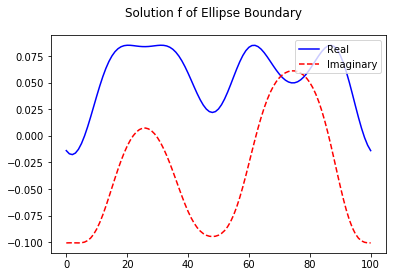

In [471]:
xbdyE, ybdyE, fE = def_f(bdy_E(θ), x0, y0);
fig, ax  = plt.subplots(1,1)
ax.plot(np.real(fE), 'b', label='Real')
ax.plot(np.imag(fE), 'r--', label='Imaginary')
ax.legend(loc='upper right');
fig.suptitle('Solution f of Ellipse Boundary');

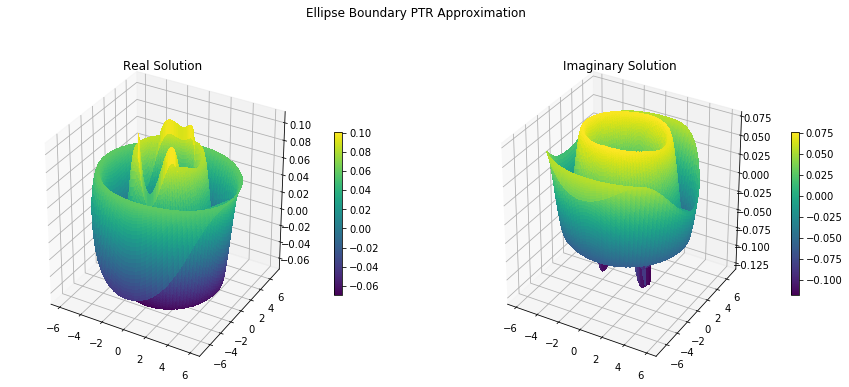

In [476]:
ngrid = 99;
μ = find_μ(fE, xbdyE, ybdyE, ν_E(θ), J_E(θ), κ_E(θ));
x, y, u = makegrid(ngrid, xbdyE, ybdyE, ν_E(θ), J_E(θ), κ_E(θ));


fig = plt.figure(figsize=(15,6))
fig.suptitle("Ellipse Boundary PTR Approximation");
ax = fig.add_subplot(1,2,1, projection='3d')
#fig.gca(projection='3d')
real = ax.plot_surface(x, y, np.real(u), rstride=1, cstride=1, cmap=plt.get_cmap('viridis'), linewidth=0, antialiased=False)
plt.title("Real Solution");
fig.colorbar(real, shrink=0.5);


#fig = plt.figure(figsize=(10,7))
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(1, 2, 2, projection='3d')
imag = ax.plot_surface(x, y, np.imag(u), rstride=1, cstride=1, cmap=plt.get_cmap('viridis'), linewidth=0, antialiased=False)
plt.title("Imaginary Solution");
fig.colorbar(imag, shrink=0.5);
#plt.show()

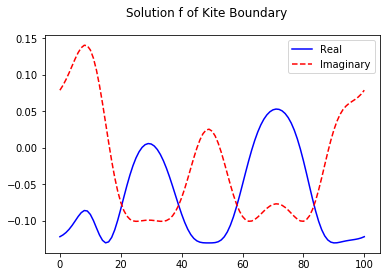

In [473]:
xbdyK, ybdyK, fK = def_f(bdy_K(θ), x0, y0);

fig, ax  = plt.subplots(1,1)
ax.plot(np.real(fK), 'b', label='Real')
ax.plot(np.imag(fK), 'r--', label='Imaginary')
ax.legend(loc='upper right');
fig.suptitle('Solution f of Kite Boundary');

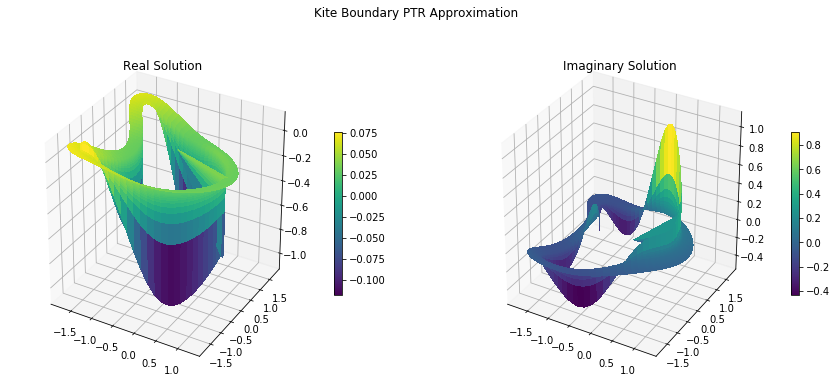

In [477]:
ngrid = 99;
μ = find_μ(fK, xbdyK, ybdyK, ν_K(θ), J_K(θ), κ_K(θ));
x, y, u = makegrid(ngrid, xbdyK, ybdyK, ν_K(θ), J_K(θ), κ_K(θ));

fig = plt.figure(figsize=(15,6))
fig.suptitle("Kite Boundary PTR Approximation");
ax = fig.add_subplot(1,2,1, projection='3d')
#fig.gca(projection='3d')
real = ax.plot_surface(x, y, np.real(u), rstride=1, cstride=1, cmap=plt.get_cmap('viridis'), linewidth=0, antialiased=False)
plt.title("Real Solution");
fig.colorbar(imag, shrink=0.5);


#fig = plt.figure(figsize=(10,7))
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(1, 2, 2, projection='3d')
imag = ax.plot_surface(x, y, np.imag(u), rstride=1, cstride=1, cmap=plt.get_cmap('viridis'), linewidth=0, antialiased=False)
plt.title("Imaginary Solution");
fig.colorbar(imag, shrink=0.5);
#plt.show()

<h3>Issues (Resolved and Unresolved)</h3>
<ul>
        <li>Left Matrix Division, Matlab v. Python - Results don't seem to match,causes final results to vary extremely - <b>RESOLVED</b></li> 
    <li>3D Surface Plot - Inside of plot being filled in, need to check indexing and intervals of functions used for ngrid calculation - <b>RESOLVED</b></li> 
    <li>Sudden spike at the end of surface plot, missing gap of data. Need to check theta range and impose periodicity - <b>RESOLVED</b></li>
</ul>